# Notebook to fit free parameters within a model to data.

In [42]:
import stlab
import stlabutils
import numpy as np
import pickle
import multiprocessing as mp
import matplotlib.pyplot as plt

from numpy import tan, pi, sqrt
from numpy.fft import fft, ifft
from scipy.optimize import minimize, curve_fit
from scipy.constants import e,h,hbar,k,G,epsilon_0
from lmfit import Model, Parameters
phi_0 = hbar/2./e
# import numdifftools
import matplotlib.pyplot as plt
%notebook inline
from qutip import *
qutip.settings.has_mkl=False
from scipy import signal
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2

from ipywidgets import IntSlider, interact, fixed, FloatSlider

# Select data

In [129]:
# Specify the path to your data file
folder = '/home/jovyan/thesis/measurements/20-01-11_Omegad_1/'
file = 'W_top_2020_01_10_16.20.43_Resonator_split_Singletone-sideband-LT142W4_5D_C_60dB_Omegad_1.dat'
filepath = folder + file

# Load the data
data = stlabutils.readdata.readdat(filepath)

#Create new data column if needed
for line in data:
    line['S21_lin ()'] = (line['S21re ()']**2 + line['S21im ()']**2)

# Specify what data you want to use for the parameter fitting
block = data[0]
xdata = np.asarray(block['Frequency (Hz)'])[130:350]
ydata = np.asarray(block['S21_lin ()'])[130:350]

['Frequency (Hz)', 'S21re ()', 'S21im ()', 'S21dB (dB)', 'S21Ph (rad)', 'Power (dBm)']


# Visualize the data

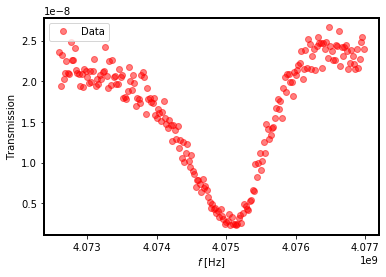

In [130]:
plt.figure()
plt.plot(xdata, ydata,'ro', label='Data', alpha=0.5)
plt.xlabel("$f$ [Hz]")
plt.ylabel("Transmission")
plt.legend()
plt.show()

# Model
Here we specify the model to be optimized.
The model is given as a function with
- the first argument: the x-coordinates (frequencie range)
- the other arguments: the parameters to be fitted.

All fixed parameters should be given inside the function as local variables or outside the function as global variables.

If you want other parameters to be fitted, just change the arguments inside the function definition.
If you have multiple models, which require different fixed parameters, I can recommend you to define them inside a model function locally.

In [137]:
def spectroscopy(wp_list, g, A, B,  gamma, detun):
    
    # Cavity (b)
    wc = 4.0752e9
    kappa = 10e6
    Nh_spec = 4
    chi = 1.278e+6
    
    # Qubit (a)
#     wq = 2*pi*4.0757e9
#     wq = 6.811e9
    wq = wc + detun
    Aq = 150e6
#     gamma = 100e3 ##homogenous linewidth
    gamma_phi = 0e3 ##inhomogenous linewidth
    Nl_spec = 4
    eps = 116.3e3
    
    A *= 1e-7
    B *= 1e-8
    g = 2*pi*g
    chi = 2*pi*chi
    wq  = 2*pi*wq
    wc  = 2*pi*wc
    gamma = 2*pi*gamma
    gamma_phi = 2*pi*gamma_phi
    Aq = 2*pi*Aq
    kappa = 2*pi*kappa
    wp_list = wp_list*2*pi
    eps = 2*pi*eps
    
    # Hamiltonian
    a = tensor(destroy(Nl_spec), qeye(Nh_spec))
    b = tensor(qeye(Nl_spec), destroy(Nh_spec))
    num_b = b.dag()*b
    num_a = a.dag()*a
    r=[]
    H0 = wq*num_a + wc*num_b - 0.5*Aq*a.dag()*a.dag()*a*a - g*(a.dag()*b.dag() + b*a)
    #    qubit      cavity     anharmonicity                coupling
    
    # Calculate spectrum
    for wp in wp_list:
        H = H0 - (wc+wq-wp)*num_a - wp*num_b + eps*1j*(b.dag()-b) - 2*chi*num_a*num_b
        #        drive      drive      drive                state-dependent frequency shift
        c_ops = [np.sqrt(gamma)*a, np.sqrt(gamma_phi)*num_a, np.sqrt(kappa)*b]  
        rho_ss = steadystate(H, c_ops)  ## steady-state since interested in f-domain
        r.append([expect(b,rho_ss)])
    
    out = A*np.array(r) + B
    
#     global xdata, ydata
#     plt.figure()
#     plt.plot(xdata, ydata,'ro', alpha=0.5, label='Data')
#     plt.plot(wp_list/2/pi, out,'b-', label='Initial guess')
#     # plt.xlim(4.073e9,4.077e9)
#     plt.title('Title')
#     plt.xlabel('Frequency (Hz)')  
#     plt.ylabel('Transmission') 
#     plt.show()
#     plt.close()
    
    return np.concatenate(out)

# Initial guess
The computer must know where to start searching for a minimum in the error function. So here we determine the initial guess of the parameters, the frequency range to compute the model for, and we plot the initial guess.

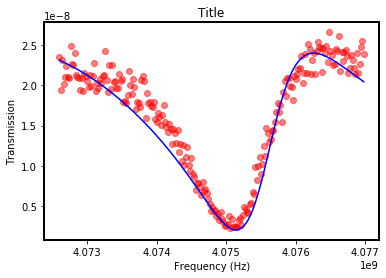

In [132]:
g = 2e6  #coupling constant
A = 11
B = 0
# eps = 166e3
# wc = 4.0755e9
detun = 1e7
gamma = 16e3
# gamma_phi = 200e3
wc = 4.0750e9

# initguess = spectroscopy(xdata, g, A, B,gamma, detun)
w_points = 200
scan =10e6
wp_list = np.linspace(xdata[0],xdata[-1],w_points)#Hz
initguess = spectroscopy(wp_list, g, A, B,gamma, detun)

plt.figure()
plt.plot(xdata, ydata,'ro', alpha=0.5, label='Data')
plt.plot(wp_list, initguess,'b-', label='Initial guess')
# plt.xlim(4.073e9,4.077e9)
plt.title('Title')
plt.xlabel('Frequency (Hz)')  
plt.ylabel('Transmission') 
plt.show()
plt.close()

In [135]:
g_slider = FloatSlider(min=5e4, max=1e7, step = 1e5)
A_slider = FloatSlider(min=5, max=50, step=1)
B_slider = FloatSlider(min=-1, max=1, step=0.1)
gamma_slider = FloatSlider(min=1e3, max=1e5, step = 5e3)
detun_slider = FloatSlider(min=-1e7, max=1e7, step = 5e6)

initguess = interact(spectroscopy, wp_list=fixed(wp_list), g=g_slider, A=A_slider, B=B_slider,
                     gamma=gamma_slider, detun=detun_slider);

interactive(children=(FloatSlider(value=50000.0, description='g', max=10000000.0, min=50000.0, step=100000.0),…

In [61]:
##### plt.figure()
# plt.plot(xdata, ydata,'ro', alpha=0.5, label='Data')
plt.plot(xdata, 10*initguess1,'r-', label='Initial guess')
plt.plot(xdata, initguess2,'b-', label='Initial guess')
plt.title('Title')
plt.xlabel('Frequency (Hz)')  
plt.ylabel('Transmission') 
plt.show()
plt.close()

NameError: name 'xdata' is not defined

# Fitting
Now it's time to look at the fitting methods.
There are two options in this notebook:
- Sequential gradient descent, developed by Wouter Kessels.
- Built-in methods from lmfit and SciPy

## A. Sequential gradient descent
The basic intuitive workflow is that it takes steps of a predefined size for each of the to be fitted variables. It continues for one variable, holding the other variables fixed, until it hits a minimum in the cost function. Subsequently it continues for the next variable. The fitting is done when a local minimum in the cost function is hit for all variables. Note that a smaller step size will increase the accuracy of the result, but the calculation time might increase dramatically as well, because the workflow is still a rigorous, unadaptive search.

The workflow and costfunction (squared error) are defined below.

In [999]:
costfun = lambda x1, x2 : sum(abs(x1 - x2)**2)

def sgd(x, ydata, model, costfun, p0, step):
    """Sequential gradient decent over all parameters of the model function.
    The basic intuitive workflow is that it takes steps of a predefined size
    for each of the to be fitted variables. It continues for one variable,
    holding the other variables fixed, until it hits a minimum in the cost
    function. Subsequently it continues for the next variable. The fitting is
    done when a local minimum in the cost function is hit for all variables.
    
    Note that a smaller step size will increase the accuracy of the result,
    but the calculation time might increase dramatically as well.
    
    Input
    -----
    x : array-like
        x-data
    ydata : array-like
        Experimental data corresponding to the x-coordinates
    model : function
        Model function with N variables
    costfun : function
        Cost function
    p0 : array-like
        Initial guess of N variables
    step : array-like
        Step size for each of N variables
    
    Returns
    -------
    paramvals : array-like
        Fitted values of the N variables
    """
    from copy import copy
    finish = False
    paramvals = copy(p0)
    sim_init = model(x, p0[0], p0[1], p0[2], p0[3])
    cost = costfun(ydata, sim_init)
    while not finish:
        changes = [False, False, False, False]
        for ipar in range(len(paramvals)):
            argsmin = copy(paramvals)
            argsmin[ipar] = paramvals[ipar] - step[ipar]
            if argsmin[ipar] < 0:
                argsmin[ipar] = 0
            argsplus = copy(paramvals)
            argsplus[ipar] = paramvals[ipar] + step[ipar]
            
            simmin = model(x, argsmin[0], argsmin[1], argsmin[2], argsmin[3])
            simplus = model(x, argsplus[0], argsplus[1], argsplus[2], argsplus[3])
            
            costmin = costfun(ydata, simmin)
            costplus = costfun(ydata, simplus)
            smallest = min([costmin, costplus])
            
            if (smallest == costmin and smallest < cost):
                stepdir = -step[ipar]
                paramvals[ipar] -= step[ipar]
                cost = copy(costmin)
                changes[ipar] = True
            elif (smallest == costplus and smallest < cost):
                stepdir = step[ipar]
                paramvals[ipar] += step[ipar]
                cost = copy(costplus)
                changes[ipar] = True
            elif (smallest > cost):
                stepdir = 0
            
            print(paramvals, cost)
            
            if stepdir != 0:
                descending = True
                while descending:
                    args = copy(paramvals)
                    args[ipar] += stepdir
                    if args[ipar] < 0:
                        args[ipar] = 0
                        descending = False
                    sim = model(x, args[0], args[1], args[2], args[3])
                    newcost = costfun(ydata, sim)
                    if newcost <= cost:
                        paramvals[ipar] = args[ipar]
                        cost = copy(newcost)
                    elif newcost > cost:
                        descending = False
                    
                    print(paramvals, cost)
            
        if True not in changes:
            finish = True
            print("Finished at local minimum")
    
    return paramvals

Execute the sequential gradient descent on the model and print the result together with the initial guess.

In [509]:
fitted_vals = sgd(xdata, ydata, spectroscopy, costfun,
                  p0=[g, power, A, B], step=[1e4, 1, 1e-7, 1e-10])
print(vals)

NameError: name 'power' is not defined

In [510]:
bestfit = spectroscopy(xdata, vals[0], vals[1], vals[2], vals[3], vals[4])

plt.figure()
plt.plot(xdata, ydata,'ro', alpha=0.6, label="Data")
plt.plot(xdata, initguess, 'k-', label='Initial guess')
plt.plot(xdata, bestfit, 'b-', label='SGD')
plt.xlabel('Readout frequency (Hz)')  
plt.ylabel('Transmission')
plt.legend()
plt.show()
plt.close()

NameError: name 'vals' is not defined

## B. lmfit's methods
The lmfit package contains dozens of Scipy-based methods to do parameter fitting. Every method has its own characteristics, some are fast, some are rigorous, some provide error estimates. You can just try different models and see which one gives the best result. The available models can be found on this page: https://lmfit.github.io/lmfit-py/fitting.html.

The resulting fits are written to a pickle file so that they are kept accessible for later times.

### 1. Least-squares

[[Model]]
    Model(spectroscopy)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 440
    # variables        = 5
    chi-square         = 6.3042e-15
    reduced chi-square = 1.4492e-17
    Akaike info crit   = -17055.1058
    Bayesian info crit = -17034.6719
##  Warning: uncertainties could not be estimated:
[[Variables]]
    g:      2278510.18 (init = 2000000)
    A:      5.81723848 (init = 11)
    B:      0.77964365 (init = 0)
    gamma:  238830.424 (init = 16000)
    detun:  3.6631e+11 (init = 1e+07)


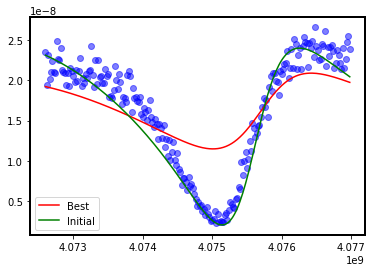

In [138]:
smodel = Model(spectroscopy)
result_leastsq = smodel.fit(ydata, wp_list=xdata, g=g, A=A, B=B ,gamma=gamma, detun=detun, nan_policy='omit',
                            method='leastsq')
# result_leastsq = smodel.fit(ydata, wd_list=xdata, g=g, A=A, B=B ,gamma=gamma,gamma_phi=gamma_phi, detun=detun, nan_policy='omit',
#                             method='leastsq')
print(result_leastsq.fit_report())

plt.plot(xdata, ydata, 'bo', alpha=0.5)
plt.plot(xdata, result_leastsq.best_fit, 'r-', label='Best')
plt.plot(xdata, result_leastsq.init_fit, 'g-', label='Initial')
plt.legend()
plt.show()

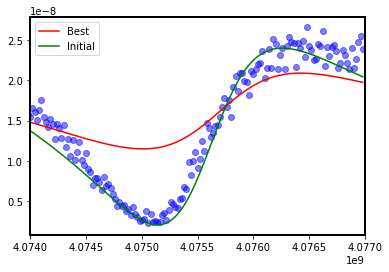

In [139]:
plt.plot(xdata, ydata, 'bo', alpha=0.5)
plt.xlim(4.074e9,4.077e9)
plt.plot(xdata, result_leastsq.best_fit, 'r-', label='Best')
plt.plot(xdata, result_leastsq.init_fit, 'g-', label='Initial')
plt.legend()
plt.show()

### 2. L-BFGS-B
https://en.wikipedia.org/wiki/Limited-memory_BFGS

In [8]:
smodel = Model(spectroscopy)
result_lbfgsb = smodel.fit(ydata, wd_list=xdata, g=g, A=A,B=B,detun=detun, gamma=gamma, nan_policy='omit',
                           method='lbfgsb')
print(result_lbfgsb.fit_report())

plt.plot(xdata, ydata, 'bo', alpha=0.5)
plt.plot(xdata, result_lbfgsb.best_fit, 'r-', label='Best')
plt.plot(xdata, result_lbfgsb.init_fit, 'g-', label='Initial')
plt.legend()
plt.show()

RuntimeError: Factor is exactly singular

### 3. Nelder-Mead
https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method

In [9]:
smodel = Model(spectroscopy)
result_nelder = smodel.fit(ydata, wd_list=xdata, g=g, A=A,B=B, detun=detun, gamma=gamma, nan_policy='omit',
                           method='nelder')
print(result_nelder.fit_report())

plt.plot(xdata, ydata, 'bo', alpha=0.5)
plt.plot(xdata, result_nelder.best_fit, 'r-', label='Best')
plt.plot(xdata, result_nelder.init_fit, 'g-', label='Initial')
plt.legend()
plt.show()

RuntimeError: Factor is exactly singular

### 4. Powell
https://en.wikipedia.org/wiki/Powell%27s_method

In [10]:
smodel = Model(spectroscopy)
result_powell = smodel.fit(ydata, wd_list=xdata, A=A,B=B,detun=detun, nan_policy='omit',
                           method='powell')
print(result_powell.fit_report())

plt.plot(xdata, ydata, 'bo', alpha=0.5)
plt.plot(xdata, result_powell.best_fit, 'r-', label='Best')
plt.plot(xdata, result_powell.init_fit, 'g-', label='Initial')
plt.legend()
plt.show()

RuntimeError: Factor is exactly singular